In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_blobs
from collections import Counter
from path import Path
import hvplot.pandas
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import mpu
from uszipcode import SearchEngine

# importing functions

In [4]:
def clean_schedule_data(df, df1):
    
    # pulling only the columns we want from the pitching log dataframe
    df = df[["Game#", "Opp", "Result", "Starting Pitcher", "Opposing Pitcher"]]
    df.set_index("Game#", inplace = True)
    
    # pulling only the columns we want from the schedule log dataframe
    df1 = df1[["Hm/Aw", "Game#"]]
    df1.set_index("Game#", inplace = True)
    
    # combining into one dataframe to work with
    return_df = pd.merge(df, df1, left_index=True, right_index=True)
    return_df.dropna(inplace=True)
    
    # changing results from W/L to 1/0
    true_w = return_df["Result"].str.contains('W', na=True)
    binary_result = []
    for row in return_df.index:
        if true_w[row]:
            binary_result.append(1)
        else:
            binary_result.append(0)
        
    return_df["Result"] = binary_result
    
    
    # getting the distance between thw two clubs
    Home = []
    Away = []
    
    x = len(return_df)
    return_df.reset_index(inplace = True)
    return_df.drop(columns = "Game#", inplace = True)
    
    for number in return_df.index:
        if return_df.loc[number]["Hm/Aw"] == "Away":
            Home.append(return_df.loc[number]["Opp"])
            Away.append("HOU")
        else:
            Home.append("HOU")
            Away.append(return_df.loc[number]["Opp"])
            
    return_df["Home"] = Home
    return_df["Away"] = Away
        
    return_df["Distance"] = [get_home_away_distance_in_miles(home, away) for home, away in zip(return_df.Home, return_df.Away)]

    return_df['Distance'] = [distance * -1 if stadium == 'Home' else distance for stadium, 
                             distance in zip(return_df['Hm/Aw'], return_df['Distance'])]
    
    
    # setting index and dropping off columns we don't need anymore
    return_df.set_index("Opp", inplace = True)
    
    return_df.drop(columns = ["Hm/Aw", "Home", "Away"], inplace = True)
    
    return return_df


def clean_batting_data(df1):
    
    # dropping last two rows as they are average and total
    df1.drop(index = [30, 31], inplace = True)
    
    # setting index to team name
    df1.set_index("Tm", inplace = True)
    
    # setting index to match for team acry df
    team_acry.set_index("Team(Bat)", inplace = True)
    
    # changing team names to match
    new_team_name = []

    for team in df1.index:
        if team in team_acry.index:
            new_team_name.append(team_acry.loc[team]["Team(New)"])
            
    df1.index = new_team_name
    
    # pulling only the metrics we want
#     df1 = df1[["BatAge", "R/G", "PA", "AB", "H", "2B", "3B", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "TB", "HBP", "LOB"]]
    df1 = df1[["BatAge", "LOB"]]

    # resetting index for team acry df
    team_acry.reset_index(inplace = True)
    
    # returning the dataframe
    return df1


def clean_pitching_data(df):
    
    # need to get rid of extra space in pitcher names
    random_number = list(range(len(df)))
    list_of_pitchers = []
    for number in random_number:
        string = df["Name"][number] 
        string = string.replace(u'\xa0', u' ')
        list_of_pitchers.append(string)
    df["Pitcher"] = list_of_pitchers
    
    # setting index to pitchers
    df = df.groupby("Pitcher").mean()
    
    # pulling only the metrics we want
    df = df[["ERA", "CG", "IP", "ERA+", "FIP", "WHIP", "H9", "HR9", "BB9", "SO9", "SO/W"]]
    
    # returning the dataframe
    return df

def get_distance_in_miles(home_team_zip, away_team_zip):        
    
    #for extensive list of zipcodes, set simple_zipcode=False
    search = SearchEngine(simple_zipcode=True)
    zip1 = search.by_zipcode(home_team_zip)
    zip2 = search.by_zipcode(away_team_zip)

    return round(mpu.haversine_distance((zip1.lat, zip1.lng), (zip2.lat, zip2.lng)), 2)

def get_home_away_distance_in_miles(home_team_code, away_team_code):
    
    teams = [
        { 'team': 'ARI', 'name': 'Arizona Diamondbacks', 'address': '401 E Jefferson St, Phoenix, AZ 85004' },
        { 'team': 'ATL', 'name': 'Atlanta Braves',  'address': '755 Battery Ave SE, Atlanta, GA 30339' },
        { 'team': 'BAL', 'name': 'Baltimore Orioles', 'address': '333 W Camden St, Baltimore, MD 21201' },
        { 'team': 'BOS', 'name': 'Boston Red Sox', 'address': '4 Jersey St, Boston, MA 02215' },
        { 'team': 'CHA', 'name': 'Chicago White Sox', 'address': '333 W 35th St, Chicago, IL 60616'},
        { 'team': 'CHN', 'name': 'Chicago Cubs', 'address': '1060 W Addison St, Chicago, IL 60613' },
        { 'team': 'CIN', 'name': 'Cincinnati Reds', 'address': '100 Joe Nuxhall Way, Cincinnati, OH 45202' }, 
        { 'team': 'CLE', 'name': 'Cleveland Indians', 'address': '2401 Ontario St, Cleveland, OH 44115' },
        { 'team': 'COL', 'name': 'Colorado Rockies', 'address': '2001 Blake St, Denver, CO 80205' },
        { 'team': 'DET', 'name': 'Detroit Tigers', 'address': '2100 Woodward Ave, Detroit, MI 48201' },
        { 'team': 'HOU', 'name': 'Houston Astros', 'address': '501 Crawford St, Houston, TX 77002' },
        { 'team': 'KCA', 'name': 'Kansas City Royals', 'address': '1 Royal Way, Kansas City, MO 64129' },
        { 'team': 'ANA', 'name': 'Los Angeles Angels', 'address': '2000 E Gene Autry Way, Anaheim, CA 92806' },
        { 'team': 'LAN', 'name': 'Los Angeles Dodgers', 'address': '1000 Vin Scully Ave, Los Angeles, CA 90012' },
        { 'team': 'MIA', 'name': 'Miami Marlins', 'address': '501 Marlins Way, Miami, FL 33125' },
        { 'team': 'MIL', 'name': 'Milwaukee Brewers', 'address': '1 Brewers Way, Milwaukee, WI 53214' },
        { 'team': 'MIN', 'name': 'Minnesota Twins', 'address': '1 Twins Way, Minneapolis, MN 55403' },
        { 'team': 'NYA', 'name': 'New York Yankees', 'address': '1 E 161 St, The Bronx, NY 10451' },
        { 'team': 'NYN', 'name': 'New York Mets', 'address': '41 Seaver Way, Queens, NY 11368' },
        { 'team': 'OAK', 'name': 'Oakland Athletics', 'address': '7000 Coliseum Way, Oakland, CA 94621' },
        { 'team': 'PHI', 'name': 'Philadelphia Phillies', 'address': '1 Citizens Bank Way, Philadelphia, PA 19148' },
        { 'team': 'PIT', 'name': 'Pittsburgh Pirates', 'address': '115 Federal St, Pittsburgh, PA 15212' },
        { 'team': 'SDN', 'name': 'San Diego Padres', 'address': '100 Park Blvd, San Diego, CA 92101' },
        { 'team': 'SFN', 'name': 'San Francisco Giants', 'address': '24 Willie Mays Plaza, San Francisco, CA 94107' },
        { 'team': 'SEA', 'name': 'Seattle Mariners', 'address': '1250 1st Ave S, Seattle, WA 98134' },
        { 'team': 'SLN', 'name': 'St. Louis Cardinals', 'address': '700 Clark Ave, St. Louis, MO 63102' },
        { 'team': 'TBA', 'name': 'Tampa Bay Rays', 'address': '1 Tropicana Dr., St. Petersburg, FL 33705' },
        { 'team': 'TEX', 'name': 'Texas Rangers', 'address': '734 Stadium Dr, Arlington, TX 76011' },
        { 'team': 'TOR', 'name': 'Toronto Blue Jays', 'address': '1 Blue Jays Way, Toronto, ON 14305' },
        { 'team': 'WAS', 'name': 'Washington Nationals', 'address': '1500 S Capitol St SE, Washington, DC 20003' }
    ]

    teams_zip_df = pd.DataFrame.from_dict(teams)

    teams_zip_df['zip'] = teams_zip_df['address'].str.split(',', expand=True)[2].str.split(' ', expand=True)[2]
    teams_zip_df.sort_values("team", inplace=True) 
    teams_zip_df.set_index('team', inplace=True)    
        
    return get_distance_in_miles(
        home_team_zip = teams_zip_df.loc[home_team_code]['zip'], 
        away_team_zip = teams_zip_df.loc[away_team_code]['zip'])

def combine_year_df(df_result_schedule, df_bat, df_pitch, team):
        
    # gathering Houston Astros batting averages
#     df_team = df_bat.loc[team]
#     df_team = pd.DataFrame(df_team)
#     df_team = df_team.transpose()
#     df_team.rename(columns = {
#         "BatAge" : "Favorite-BatAge", 
#         "R/G" : "Favorite-R/G", 
#         "PA" : "Favorite-PA", 
#         "AB" : "Favorite-AB", 
#         "H" : "Favorite-H", 
#         "2B" : "Favorite-2B", 
#         "3B" : "Favorite-3B", 
#         "HR" : "Favorite-HR",
#         "BB" : "Favorite-BB", 
#         "SO" : "Favorite-SO", 
#         "BA" : "Favorite-BA", 
#         "OBP" : "Favorite-OBP", 
#         "SLG" : "Favorite-SLG", 
#         "OPS" : "Favorite-OPS", 
#         "TB" : "Favorite-TB", 
#         "HBP" : "Favorite-HBP", 
#         "LOB" : "Favorite-LOB",
#                 }, inplace=True)

    
    # merging databases
    merge_df = pd.merge(df_result_schedule, df_bat, left_index=True, right_index=True)
#     df_team["key"] = 1
#     merge_df["key"] = 1
#     df = pd.merge(df_team, merge_df, on='key')
#     del df['key']
    
    # pulling metrics for the pitchers    
    random_number = list(range(len(df)))
    
    opp_pitch_class = []
    opp_pitch_class_2 = []
    opp_pitch_class_3 = []
    opp_pitch_class_4 = []
    opp_pitch_class_5 = []
    opp_pitch_class_6 = []
    opp_pitch_class_7 = []
    opp_pitch_class_8 = []
    opp_pitch_class_9 = []
    opp_pitch_class_10 = []
    opp_pitch_class_11 = []
    
    for number in random_number:
        if df["Opposing Pitcher"][number] in df_pitch.index:
            name = df["Opposing Pitcher"][number]
            opp_pitch_class.append(df_pitch.loc[name]["ERA"])
#             opp_pitch_class_2.append(df_pitch.loc[name]["CG"])
            opp_pitch_class_3.append(df_pitch.loc[name]["IP"])
            opp_pitch_class_4.append(df_pitch.loc[name]["ERA+"])
            opp_pitch_class_5.append(df_pitch.loc[name]["FIP"])
            opp_pitch_class_6.append(df_pitch.loc[name]["WHIP"])
            opp_pitch_class_7.append(df_pitch.loc[name]["H9"])
            opp_pitch_class_8.append(df_pitch.loc[name]["HR9"])
            opp_pitch_class_9.append(df_pitch.loc[name]["BB9"])
            opp_pitch_class_10.append(df_pitch.loc[name]["SO9"])
            opp_pitch_class_11.append(df_pitch.loc[name]["SO/W"])
        else:
            opp_pitch_class.append(0)
#             opp_pitch_class_2.append("N/A")
            opp_pitch_class_3.append("N/A")
            opp_pitch_class_4.append("N/A")
            opp_pitch_class_5.append("N/A")
            opp_pitch_class_6.append("N/A")
            opp_pitch_class_7.append("N/A")
            opp_pitch_class_8.append("N/A")
            opp_pitch_class_9.append("N/A")
            opp_pitch_class_10.append("N/A")
            opp_pitch_class_11.append("N/A")

    start_pitch_class = []
    start_pitch_class_2 = []
    start_pitch_class_3 = []
    start_pitch_class_4 = []
    start_pitch_class_5 = []
    start_pitch_class_6 = []
    start_pitch_class_7 = []
    start_pitch_class_8 = []
    start_pitch_class_9 = []
    start_pitch_class_10 = []
    start_pitch_class_11 = []
       
    for number in random_number:
        if df["Starting Pitcher"][number] in df_pitch.index:
            name = df["Starting Pitcher"][number]
            start_pitch_class.append(df_pitch.loc[name]["ERA"])
#             start_pitch_class_2.append(df_pitch.loc[name]["CG"])
            start_pitch_class_3.append(df_pitch.loc[name]["IP"])
            start_pitch_class_4.append(df_pitch.loc[name]["ERA+"])
            start_pitch_class_5.append(df_pitch.loc[name]["FIP"])
            start_pitch_class_6.append(df_pitch.loc[name]["WHIP"])
            start_pitch_class_7.append(df_pitch.loc[name]["H9"])
            start_pitch_class_8.append(df_pitch.loc[name]["HR9"])
            start_pitch_class_9.append(df_pitch.loc[name]["BB9"])
            start_pitch_class_10.append(df_pitch.loc[name]["SO9"])
            start_pitch_class_11.append(df_pitch.loc[name]["SO/W"])
        else:
            start_pitch_class.append(0)
#             start_pitch_class_2.append("N/A")
            start_pitch_class_3.append("N/A")
            start_pitch_class_4.append("N/A")
            start_pitch_class_5.append("N/A")
            start_pitch_class_6.append("N/A")
            start_pitch_class_7.append("N/A")
            start_pitch_class_8.append("N/A")
            start_pitch_class_9.append("N/A")
            start_pitch_class_10.append("N/A")
            start_pitch_class_11.append("N/A")
    
    # adding all the pitching metrics
    return_df = df
    return_df["ERA_Starting"] = start_pitch_class
    return_df["ERA_Opposing"] = opp_pitch_class
#     return_df["CG_Starting"] = start_pitch_class_2
#     return_df["CG_Opposing"] = opp_pitch_class_2
    return_df["IP_Starting"] = start_pitch_class_3
    return_df["IP_Opposing"] = opp_pitch_class_3
    return_df["ERA+_Starting "] = start_pitch_class_4
    return_df["ERA+_Opposing"] = opp_pitch_class_4
    return_df["FIP_Starting"] = start_pitch_class_5
    return_df["FIP_Opposing"] = opp_pitch_class_5
    return_df["WHIP_Starting"] = start_pitch_class_6
    return_df["WHIP_Opposing"] = opp_pitch_class_6
    return_df["H9_Starting "] = start_pitch_class_7
    return_df["H9_Opposing"] = opp_pitch_class_7
    return_df["HR9_Starting"] = start_pitch_class_8
    return_df["HR9_Opposing"] = opp_pitch_class_8
    return_df["BB9_Starting"] = start_pitch_class_9
    return_df["BB9_Opposing"] = opp_pitch_class_9
    return_df["SO9_Starting "] = start_pitch_class_10
    return_df["SO9_Opposing"] = opp_pitch_class_10
    return_df["SO/W_Starting"] = start_pitch_class_11
    return_df["SO/W_Opposing"] = opp_pitch_class_10
    
    # deleting any rows where pitcher data was not found
    return_df = return_df[return_df.HR9_Starting != "N/A"]
    return_df = return_df[return_df.HR9_Opposing != "N/A"]
#     return_df = return_df[return_df.ERA_Starting != 0]
#     return_df = return_df[return_df.ERA_Opposing != 0]
    
    # dropping starting and opposing pitcher as we have their metrics now
    return_df.drop(["Starting Pitcher", "Opposing Pitcher"], axis=1, inplace = True)
    
    # returning dataframe
    return return_df


def determine_who_wins(starting_pitcher, opposing_pitcher, home_or_away):
    
    
    # gathering pitching data from two inputs in the function
    opp_pitch_class = []
    opp_pitch_class_2 = []
    opp_pitch_class_3 = []
    opp_pitch_class_4 = []
    opp_pitch_class_5 = []
    opp_pitch_class_6 = []
    opp_pitch_class_7 = []
    opp_pitch_class_8 = []
    opp_pitch_class_9 = []
    opp_pitch_class_10 = []
    opp_pitch_class_11 = []
    
    if opposing_pitcher in df_pitch.index:
        opp_pitch_class.append(df_pitch.loc[opposing_pitcher]["ERA"])
#         opp_pitch_class_2.append(df_pitch.loc[opposing_pitcher]["CG"])
        opp_pitch_class_3.append(df_pitch.loc[opposing_pitcher]["IP"])
        opp_pitch_class_4.append(df_pitch.loc[opposing_pitcher]["ERA+"])
        opp_pitch_class_5.append(df_pitch.loc[opposing_pitcher]["FIP"])
        opp_pitch_class_6.append(df_pitch.loc[opposing_pitcher]["WHIP"])
        opp_pitch_class_7.append(df_pitch.loc[opposing_pitcher]["H9"])
        opp_pitch_class_8.append(df_pitch.loc[opposing_pitcher]["HR9"])
        opp_pitch_class_9.append(df_pitch.loc[opposing_pitcher]["BB9"])
        opp_pitch_class_10.append(df_pitch.loc[opposing_pitcher]["SO9"])
        opp_pitch_class_11.append(df_pitch.loc[opposing_pitcher]["SO/W"])
    else:
        print("Opposing Pitcher Not Found")

    
    start_pitch_class = []
    start_pitch_class_2 = []
    start_pitch_class_3 = []
    start_pitch_class_4 = []
    start_pitch_class_5 = []
    start_pitch_class_6 = []
    start_pitch_class_7 = []
    start_pitch_class_8 = []
    start_pitch_class_9 = []
    start_pitch_class_10 = []
    start_pitch_class_11 = []
       
    if starting_pitcher in df_pitch.index:
        start_pitch_class.append(df_pitch.loc[starting_pitcher]["ERA"])
#         start_pitch_class_2.append(df_pitch.loc[starting_pitcher]["CG"])
        start_pitch_class_3.append(df_pitch.loc[starting_pitcher]["IP"])
        start_pitch_class_4.append(df_pitch.loc[starting_pitcher]["ERA+"])
        start_pitch_class_5.append(df_pitch.loc[starting_pitcher]["FIP"])
        start_pitch_class_6.append(df_pitch.loc[starting_pitcher]["WHIP"])
        start_pitch_class_7.append(df_pitch.loc[starting_pitcher]["H9"])
        start_pitch_class_8.append(df_pitch.loc[starting_pitcher]["HR9"])
        start_pitch_class_9.append(df_pitch.loc[starting_pitcher]["BB9"])
        start_pitch_class_10.append(df_pitch.loc[starting_pitcher]["SO9"])
        start_pitch_class_11.append(df_pitch.loc[starting_pitcher]["SO/W"])
    else:
        print("Starting Pitcher Not Found")    
        
        
    # gathering batting metrics from pitchers' team
    if opposing_pitcher in team_rooster.index:
        opp_team_name = team_rooster.loc[opposing_pitcher]["Team Name"]
    
    if opp_team_name in df_bat.index:
        opp_team_metrics = df_bat.loc[opp_team_name]
        
    opp_team = pd.DataFrame(opp_team_metrics)
    opp_team = opp_team.transpose()
#     opp_team = opp_team[["BatAge", "R/G", "PA", "AB", "H", "2B", "3B", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "TB", "HBP", "LOB"]]
    opp_team = opp_team[["BatAge", "LOB"]]
#     opp_team["key"] = 1

#     if starting_pitcher in team_rooster.index:
#         team_name = team_rooster.loc[opposing_pitcher]["Team Name"]
    
#     if team_name in df_bat.index:
#         team = df_bat.loc[team_name]
        
#     team = pd.DataFrame(team)
#     team = team.transpose()
#     team = team[["BatAge", "R/G", "PA", "AB", "H", "2B", "3B", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "TB", "HBP", "LOB"]]
#     team.rename(columns = {
#         "BatAge" : "Favorite-BatAge", 
#         "R/G" : "Favorite-R/G", 
#         "PA" : "Favorite-PA", 
#         "AB" : "Favorite-AB", 
#         "H" : "Favorite-H", 
#         "2B" : "Favorite-2B", 
#         "3B" : "Favorite-3B", 
#         "HR" : "Favorite-HR",
#         "BB" : "Favorite-BB", 
#         "SO" : "Favorite-SO", 
#         "BA" : "Favorite-BA", 
#         "OBP" : "Favorite-OBP", 
#         "SLG" : "Favorite-SLG", 
#         "OPS" : "Favorite-OPS", 
#         "TB" : "Favorite-TB", 
#         "HBP" : "Favorite-HBP", 
#         "LOB" : "Favorite-LOB",
#                 }, inplace=True)
#     team["key"] = 1    
    
    
    # gathering distance between teams
    distance = get_home_away_distance_in_miles(team_name, opp_team_name)
    
    if home_or_away == "Away":
        team["Distance"] = distance
    else:
        team["Distance"] = (distance * -1)
    
        
    # creating a dataframe to combine all the pitching metrics    
    pitching_metrics = pd.DataFrame(
    {     
        "ERA-Starting" : start_pitch_class,
        "ERA-Opposing" : opp_pitch_class,
#         "CG-Starting" : start_pitch_class_2,
#         "CG-Opposing" : opp_pitch_class_2,
        "IP-Starting" : start_pitch_class_3,
        "IP-Opposing" : opp_pitch_class_3,
        "ERA+-Starting" : start_pitch_class_4,
        "ERA+-Opposing" : opp_pitch_class_4,
        "FIP-Starting" : start_pitch_class_5,
        "FIP-Opposing" : opp_pitch_class_5,
        "WHIP-Starting" : start_pitch_class_6,
        "WHIP-Opposing" : opp_pitch_class_6,
        "H9-Starting" : start_pitch_class_7,
        "H9-Opposing" : opp_pitch_class_7,
        "HR9-Starting" : start_pitch_class_8,
        "HR9-Opposing" : opp_pitch_class_8,
        "BB9-Starting" : start_pitch_class_9,
        "BB9-Opposing" : opp_pitch_class_9,
        "SO9-Starting" : start_pitch_class_10,
        "SO9-Opposing" : opp_pitch_class_10,
        "SO/W-Starting" : start_pitch_class_11,
        "SO/W-Opposing" : opp_pitch_class_10,
        "key" : 1
    })
    
    
    # creating test data to run through model
#     batting_metrics = pd.merge(team, opp_team, on='key')
#     test_data = pd.merge(batting_metrics, pitching_metrics, on="key")
    test_data = pd.merge(opp_team, pitching_metrics, on="key")
    test_data.drop(["key"], axis=1, inplace = True)
    
    # testing to see what the results look like before running a model
    # it works, I can comment this out
#     result = test_data
    
    # running our model
    predictions = model.predict(test_data)
    
    outcome = predictions[0]
    
    if outcome > 0:
        print("The Astros will win!")
    else:
        print("The Astros will lose. :(")
    #printing out our prediction
    return

In [4]:
def one_off(df):
    df.set_index(["Player"], inplace = True)
    df = df.groupby(level = 0).mean()
    df = df[["ERA", "WHIP", "K", "SHO", "IP"]]
    return df

In [5]:
def one_off_2(df_result_schedule, df_bat, df_pitch, team):
        
    # gathering Houston Astros batting averages
    df_team = df_bat.loc[team]
    df_team = pd.DataFrame(df_team)
    df_team = df_team.transpose()
    df_team.rename(columns = {
        "BatAge" : "Favorite-BatAge", 
        "R/G" : "Favorite-R/G", 
        "PA" : "Favorite-PA", 
        "AB" : "Favorite-AB", 
        "H" : "Favorite-H", 
        "2B" : "Favorite-2B", 
        "3B" : "Favorite-3B", 
        "HR" : "Favorite-HR",
        "BB" : "Favorite-BB", 
        "SO" : "Favorite-SO", 
        "BA" : "Favorite-BA", 
        "OBP" : "Favorite-OBP", 
        "SLG" : "Favorite-SLG", 
        "OPS" : "Favorite-OPS", 
        "TB" : "Favorite-TB", 
        "HBP" : "Favorite-HBP", 
        "LOB" : "Favorite-LOB",
                }, inplace=True)
    
    # merging databases
    merge_df = pd.merge(df_result_schedule, df_bat, left_index=True, right_index=True)
    df_team["key"] = 1
    merge_df["key"] = 1
    df = pd.merge(df_team, merge_df, on='key')
    del df['key']
    
    # pulling metrics for the pitchers    
    random_number = list(range(len(df)))
    
    opp_pitch_class = []
    opp_pitch_class_2 = []
    opp_pitch_class_3 = []
    opp_pitch_class_4 = []
    opp_pitch_class_5 = []
    
    for number in random_number:
        if df["Opposing Pitcher"][number] in df_pitch.index:
            name = df["Opposing Pitcher"][number]
            opp_pitch_class.append(df_pitch.loc[name]["ERA"])
            opp_pitch_class_2.append(df_pitch.loc[name]["WHIP"])
            opp_pitch_class_3.append(df_pitch.loc[name]["K"])
            opp_pitch_class_4.append(df_pitch.loc[name]["SHO"])
            opp_pitch_class_5.append(df_pitch.loc[name]["IP"])

        else:
            opp_pitch_class.append(0)
            opp_pitch_class_2.append(0)
            opp_pitch_class_3.append(0)
            opp_pitch_class_4.append(0)
            opp_pitch_class_5.append(0)


    start_pitch_class = []
    start_pitch_class_2 = []
    start_pitch_class_3 = []
    start_pitch_class_4 = []
    start_pitch_class_5 = []
       
    for number in random_number:
        if df["Starting Pitcher"][number] in df_pitch.index:
            name = df["Starting Pitcher"][number]
            start_pitch_class.append(df_pitch.loc[name]["ERA"])
            start_pitch_class_2.append(df_pitch.loc[name]["WHIP"])
            start_pitch_class_3.append(df_pitch.loc[name]["K"])
            start_pitch_class_4.append(df_pitch.loc[name]["SHO"])
            start_pitch_class_5.append(df_pitch.loc[name]["IP"])

        else:
            start_pitch_class.append(0)
            start_pitch_class_2.append(0)
            start_pitch_class_3.append(0)
            start_pitch_class_4.append(0)
            start_pitch_class_5.append(0)

    
    # adding all the pitching metrics
    return_df = df
    return_df["ERA_Starting"] = start_pitch_class
    return_df["ERA_Opposing"] = opp_pitch_class
    return_df["CG_Starting"] = start_pitch_class_2
    return_df["CG_Opposing"] = opp_pitch_class_2
    return_df["IP_Starting"] = start_pitch_class_3
    return_df["IP_Opposing"] = opp_pitch_class_3
    return_df["ERA+_Starting "] = start_pitch_class_4
    return_df["ERA+_Opposing"] = opp_pitch_class_4
    return_df["FIP_Starting"] = start_pitch_class_5
    return_df["FIP_Opposing"] = opp_pitch_class_5
    
    # deleting any rows where pitcher data was not found
    return_df = return_df[return_df.ERA_Starting != 0]
    return_df = return_df[return_df.ERA_Opposing != 0]
    
    # dropping starting and opposing pitcher as we have their metrics now
    return_df.drop(["Starting Pitcher", "Opposing Pitcher"], axis=1, inplace = True)
    
    # returning dataframe
    return return_df

In [6]:
def determine_who_wins_rotoworld(starting_pitcher, opposing_pitcher, home_or_away):
    
    
    # gathering pitching data from two inputs in the function
    opp_pitch_class = []
    opp_pitch_class_2 = []
    opp_pitch_class_3 = []
    opp_pitch_class_4 = []
    opp_pitch_class_5 = []
    
    if opposing_pitcher in df_pitch.index:
        opp_pitch_class.append(df_pitch.loc[opposing_pitcher]["ERA"])
        opp_pitch_class_2.append(df_pitch.loc[opposing_pitcher]["WHIP"])
        opp_pitch_class_3.append(df_pitch.loc[opposing_pitcher]["K"])
        opp_pitch_class_4.append(df_pitch.loc[opposing_pitcher]["SHO"])
        opp_pitch_class_5.append(df_pitch.loc[opposing_pitcher]["IP"])


    start_pitch_class = []
    start_pitch_class_2 = []
    start_pitch_class_3 = []
    start_pitch_class_4 = []
    start_pitch_class_5 = []
       
    if starting_pitcher in df_pitch.index:
        start_pitch_class.append(df_pitch.loc[starting_pitcher]["ERA"])
        start_pitch_class_2.append(df_pitch.loc[starting_pitcher]["WHIP"])
        start_pitch_class_3.append(df_pitch.loc[starting_pitcher]["K"])
        start_pitch_class_4.append(df_pitch.loc[starting_pitcher]["SHO"])
        start_pitch_class_5.append(df_pitch.loc[starting_pitcher]["IP"])
    
        
        
    # gathering batting metrics from pitchers' team    
    if opposing_pitcher in team_rooster.index:
        opp_team_name = team_rooster.loc[opposing_pitcher]["Team Name"]
    
    if opp_team_name in df_bat.index:
        opp_team_metrics = df_bat.loc[opp_team_name]
        opp_team = pd.DataFrame(opp_team_metrics)
        opp_team = opp_team.transpose()
        opp_team = opp_team[["BatAge", "R/G", "PA", "AB", "H", "2B", "3B", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "TB", "HBP", "LOB"]]
        opp_team["key"] = 1

    if starting_pitcher in team_rooster.index:
        team_name = team_rooster.loc[starting_pitcher]["Team Name"]
    
    if team_name in df_bat.index:
        team = df_bat.loc[team_name]
        team = pd.DataFrame(team)
        team = team.transpose()
        team = team[["BatAge", "R/G", "PA", "AB", "H", "2B", "3B", "HR", "BB", "SO", "BA", "OBP", "SLG", "OPS", "TB", "HBP", "LOB"]]
        team.rename(columns = {
        "BatAge" : "Favorite-BatAge", 
        "R/G" : "Favorite-R/G", 
        "PA" : "Favorite-PA", 
        "AB" : "Favorite-AB", 
        "H" : "Favorite-H", 
        "2B" : "Favorite-2B", 
        "3B" : "Favorite-3B", 
        "HR" : "Favorite-HR",
        "BB" : "Favorite-BB", 
        "SO" : "Favorite-SO", 
        "BA" : "Favorite-BA", 
        "OBP" : "Favorite-OBP", 
        "SLG" : "Favorite-SLG", 
        "OPS" : "Favorite-OPS", 
        "TB" : "Favorite-TB", 
        "HBP" : "Favorite-HBP", 
        "LOB" : "Favorite-LOB",
        }, inplace = True)
        team["key"] = 1    

    
    
    # gathering distance between teams
    distance = get_home_away_distance_in_miles(team_name, opp_team_name)
    
    if home_or_away == "Away":
        team["Distance"] = distance
    else:
        team["Distance"] = (distance * -1)
    
        
    # creating a dataframe to combine all the pitching metrics    
    pitching_metrics = pd.DataFrame(
    {     
        "ERA_Starting" : start_pitch_class,
        "ERA_Opposing" : opp_pitch_class,
        "CG_Starting" : start_pitch_class_2,
        "CG_Opposing" : opp_pitch_class_2,
        "IP_Starting" : start_pitch_class_3,
        "IP_Opposing" : opp_pitch_class_3,
        "ERA+_Starting" : start_pitch_class_4,
        "ERA+_Opposing" : opp_pitch_class_4,
        "FIP_Starting" : start_pitch_class_5,
        "FIP_Opposing" : opp_pitch_class_5,
        "key" : 1
    })
    
    
    # creating test data to run through model
    batting_metrics = pd.merge(team, opp_team, on='key')
    test_data = pd.merge(batting_metrics, pitching_metrics, on="key")
    test_data.drop(["key"], axis=1, inplace = True)
    
    # testing to see what the results look like before running a model
    # it works, I can comment this out
    result = team
    
    # running our model
    result = model.predict(test_data)
    
    #printing out our prediction
    return result

In [35]:
determine_who_wins("Dallas Keuchel", "Chris Bassitt", "Home")

Opposing Pitcher Not Found
Starting Pitcher Not Found


NameError: name 'model' is not defined

In [77]:
determine_who_wins( "Chris Bassitt", "Dallas Keuchel", "Away")

array([1], dtype=int64)

In [45]:
# Astros vs Mariners 09/23/20
determine_who_wins("Zack Greinke", "Nick Margevicius", "Away")

The Astros will win!


In [47]:
# Astros vs Rangers 09/24/20
# determine_who_wins("Cristian Javier", "Lance Lynn", "Away")

In [49]:
# # Astros vs Rangers 09/25/20
# determine_who_wins("Jose Urquidy", "Kyle Cody", "Away")

In [52]:
# # Astros vs Rangers 09/26/20
# determine_who_wins("Lance McCullers Jr.", "Kyle Gibson", "Away")

In [44]:
# Astros vs Rangers 09/27/20
determine_who_wins("Chase De Jong", "Jordan Lyles", "Away")

The Astros will lose. :(


In [42]:
# Astros vs Twins 09/29/20
determine_who_wins("Zack Greinke", "Kenta Maeda", "Away")

The Astros will win!


In [39]:
# Astros vs Twins 09/30/20
determine_who_wins("Jose Urquidy", "Jose Berrios", "Away")

The Astros will lose. :(


In [74]:
# Minnesota vs Houston prediction Game Day 09/30/20
determine_who_wins("Masahiro Tanaka", "Carlos Carrasco", "Away")

UnboundLocalError: local variable 'opp_team_metrics' referenced before assignment

In [36]:
# # Minnesota vs Houston prediction Game Day 09/30/20
# determine_who_wins("Sixto Sanchez", "Yu Darvish", "Away")

In [75]:
model

BalancedRandomForestClassifier(random_state=1)

# importing in data

In [5]:
team_acry = pd.read_csv(Path("../Jack/Resources/team_acry.csv"))

team_rooster = pd.read_csv(Path("Data/misc/updated_team_rooster.csv"))
team_rooster.set_index("Player Name", inplace = True)

In [8]:
# team_acry.set_index("Team_Names", inplace = True)

# new_team_name = []
# len_of_active_rooster = list(range(len(team_rooster)))
# for number in len_of_active_rooster:
#     if team_rooster.iloc[number]["Team Name"] in team_acry.index:
#         print(team_rooster.iloc[number]["Team Name"])
#         new_team_name.append(team_acry.loc[team_rooster.iloc[number]["Team Name"]]["Team(New)"])
# #         new_team_name.append(team_acry.loc[number]["Team(New)"])
#     else:
#         new_team_name.append("0")
#         if team in team_acry.index:
#             new_team_name.append(team_acry.loc[team]["Team(New)"])

In [6]:
df_pitch_2019 = pd.read_csv(Path("../Jack/updated pitching data/2019_pitching.csv"))
df_pitch_2018 = pd.read_csv(Path("../Jack/updated pitching data/2018_pitching.csv"))
df_pitch_2017 = pd.read_csv(Path("../Jack/updated pitching data/2017_pitching.csv"))
df_pitch_2016 = pd.read_csv(Path("../Jack/updated pitching data/2016_pitching.csv"))
df_pitch_2015 = pd.read_csv(Path("../Jack/updated pitching data/2015_pitching.csv"))
df_pitch_2014 = pd.read_csv(Path("../Jack/updated pitching data/2014_pitching.csv"))
df_pitch_2013 = pd.read_csv(Path("../Jack/updated pitching data/2013_pitching.csv"))
df_pitch = pd.read_csv(Path("../Jack/updated pitching data/2019_pitching.csv"))

In [7]:
df_pitch = clean_pitching_data(df_pitch)
df_pitch.head()

,ERA,CG,IP,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
Pitcher,,,,,,,,,,,
A.J. Cole,3.81,0.0,26.0,126.0,3.83,1.500,10.7,1.4,2.8,10.4,3.75
A.J. Minter,7.06,0.0,29.1,66.0,4.61,2.011,11.0,0.9,7.1,10.7,1.52
A.J. Puk,3.18,0.0,11.1,138.0,3.39,1.324,7.9,0.8,4.0,10.3,2.60
AJ Reed,0.00,0.0,1.0,NaN,3.21,0.000,0.0,0.0,0.0,0.0,NaN
Aaron Altherr,9.00,0.0,1.0,83.0,-0.79,2.000,18.0,0.0,0.0,18.0,NaN


In [41]:
# df_pitch = pd.read_csv(Path("Data/pitch/pitch_2020.csv"))
# df_pitch.set_index("Player", inplace = True)
# df_pitch_2019 = pd.read_csv(Path("Data/pitch/pitch_2019.csv"))
# df_pitch_2018 = pd.read_csv(Path("Data/pitch/pitch_2018.csv"))
# df_pitch_2017 = pd.read_csv(Path("Data/pitch/pitch_2017.csv"))
# df_pitch_2016 = pd.read_csv(Path("Data/pitch/pitch_2016.csv"))
# df_pitch_2015 = pd.read_csv(Path("Data/pitch/pitch_2015.csv"))
# df_pitch_2014 = pd.read_csv(Path("Data/pitch/pitch_2014.csv"))
# df_pitch_2013 = pd.read_csv(Path("Data/pitch/pitch_2013.csv"))

In [8]:
df_bat_2019 = pd.read_csv(Path("../Jack/Resources/batting_2019.csv"))
df_bat_2018 = pd.read_csv(Path("../Jack/Resources/batting_2018.csv"))
df_bat_2017 = pd.read_csv(Path("../Jack/Resources/batting_2017.csv"))
df_bat_2016 = pd.read_csv(Path("../Jack/Resources/batting_2016.csv"))
df_bat_2015 = pd.read_csv(Path("../Jack/Resources/batting_2015.csv"))
df_bat_2014 = pd.read_csv(Path("../Jack/Resources/batting_2014.csv"))
df_bat_2013 = pd.read_csv(Path("../Jack/Resources/batting_2013.csv"))
df_bat = df_bat_2019
# df_bat.set_index("Tm", inplace = True)

In [9]:
# clean_batting_data(df_bat)

In [10]:
df_schedule_2019 = pd.read_csv(Path("../Jack/Resources/2019_astros_sced.csv"))
df_schedule_2018 = pd.read_csv(Path("../Jack/Resources/2018_astros_sced.csv"))
df_schedule_2017 = pd.read_csv(Path("../Jack/Resources/2017_astros_sced.csv"))
df_schedule_2016 = pd.read_csv(Path("../Jack/Resources/2016_astros_sced.csv"))
df_schedule_2015 = pd.read_csv(Path("../Jack/Resources/2015_astros_sced.csv"))
df_schedule_2014 = pd.read_csv(Path("../Jack/Resources/2014_astros_sced.csv"))
df_schedule_2013 = pd.read_csv(Path("../Jack/Resources/2013_astros_sced.csv"))

In [11]:
df_home_away_2019 = pd.read_csv(Path("../Jack/Resources/2019_home_away.txt"))
df_home_away_2018 = pd.read_csv(Path("../Jack/Resources/2018_home_away.txt"))
df_home_away_2017 = pd.read_csv(Path("../Jack/Resources/2017_home_away.txt"))
df_home_away_2016 = pd.read_csv(Path("../Jack/Resources/2016_home_away.txt"))
df_home_away_2015 = pd.read_csv(Path("../Jack/Resources/2015_home_away.txt"))
df_home_away_2014 = pd.read_csv(Path("../Jack/Resources/2014_home_away.txt"))
df_home_away_2013 = pd.read_csv(Path("../Jack/Resources/2013_home_away.txt"))

In [12]:
df_2019 = combine_year_df(
    clean_schedule_data(df_schedule_2019,df_home_away_2019), 
    clean_batting_data(df_bat_2019), 
    clean_pitching_data(df_pitch_2019),
    "HOU"
)
df_2019.head()

NameError: name 'df' is not defined

In [ ]:
df_2018 = combine_year_df(
    clean_schedule_data(df_schedule_2018,df_home_away_2018), 
    clean_batting_data(df_bat_2018), 
    clean_pitching_data(df_pitch_2018),
    "HOU"
)
df_2018.head()

In [ ]:
df_2017 = combine_year_df(clean_schedule_data(
    df_schedule_2017,df_home_away_2017), 
    clean_batting_data(df_bat_2017), 
    clean_pitching_data(df_pitch_2017),
    "HOU"
)
df_2017.head()

In [ ]:
df_2016 = combine_year_df(clean_schedule_data(
    df_schedule_2016,df_home_away_2016), 
    clean_batting_data(df_bat_2016), 
    clean_pitching_data(df_pitch_2016),
    "HOU"
)
df_2016.head()

In [ ]:
df_2015 = combine_year_df(clean_schedule_data(
    df_schedule_2015,df_home_away_2015), 
    clean_batting_data(df_bat_2015), 
    clean_pitching_data(df_pitch_2015),    
    "HOU"
)
df_2015.head()

In [ ]:
df_2014 = combine_year_df(clean_schedule_data(
    df_schedule_2014,df_home_away_2014), 
    clean_batting_data(df_bat_2014), 
    clean_pitching_data(df_pitch_2014),
    "HOU"
)
df_2014.head()

In [13]:
df_2013 = combine_year_df(clean_schedule_data(
    df_schedule_2013,df_home_away_2013), 
    clean_batting_data(df_bat_2013), 
    clean_pitching_data(df_pitch_2013),
    "HOU"
)
df_2013.head()

NameError: name 'df' is not defined

In [70]:
# df_2019 = one_off_2(
#     clean_schedule_data(df_schedule_2019,df_home_away_2019), 
#     clean_batting_data(df_bat_2019), 
#     one_off(df_pitch_2019),
#     "HOU"
# )
# df_2019.head()

In [71]:
# df_2018 = one_off_2(
#     clean_schedule_data(df_schedule_2018,df_home_away_2018), 
#     clean_batting_data(df_bat_2018), 
#     one_off(df_pitch_2018),
#     "HOU"
# )
# df_2018.head()

In [72]:
# df_2017 = one_off_2(
#     clean_schedule_data(df_schedule_2017,df_home_away_2017), 
#     clean_batting_data(df_bat_2017), 
#     one_off(df_pitch_2017),
#     "HOU"
# )
# df_2017.head()

In [73]:
# df_2016 = one_off_2(clean_schedule_data(
#     df_schedule_2016,df_home_away_2016), 
#     clean_batting_data(df_bat_2016), 
#     one_off(df_pitch_2016),
#     "HOU"
# )
# df_2016.head()

In [74]:
# df_2015 = one_off_2(clean_schedule_data(
#     df_schedule_2015,df_home_away_2015), 
#     clean_batting_data(df_bat_2015), 
#     one_off(df_pitch_2015),
#     "HOU"
# )
# df_2015.head()

In [75]:
# df_2014 = one_off_2(clean_schedule_data(
#     df_schedule_2014,df_home_away_2014), 
#     clean_batting_data(df_bat_2014), 
#     one_off(df_pitch_2014),
#     "HOU"
# )
# df_2014.head()

In [76]:
# df_2013 = one_off_2(clean_schedule_data(
#     df_schedule_2013,df_home_away_2013), 
#     clean_batting_data(df_bat_2013), 
#     one_off(df_pitch_2013),
#     "HOU"
# )
# df_2013.head()

In [53]:
print(len(df_2019))
print(len(df_2018))
print(len(df_2017))
print(len(df_2016))
print(len(df_2015))
print(len(df_2014))
print(len(df_2013))

153
135
136
144
125
157
154


In [50]:
df = pd.read_csv(Path("Data/complete_dataframes/2013_2019_Astros_full_new_pitch_data.csv"))
result = df
result.dropna()

,Favorite-BatAge,Favorite-R/G,Favorite-PA,Favorite-AB,Favorite-H,Favorite-2B,Favorite-3B,Favorite-HR,Favorite-BB,Favorite-SO,...,H9_Starting,H9_Opposing,HR9_Starting,HR9_Opposing,BB9_Starting,BB9_Opposing,SO9_Starting,SO9_Opposing,SO/W_Starting,SO/W_Opposing
0,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,8.8,9.8,1.2,2.2,3.3,3.4,7.5,7.1,2.30,7.1
1,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,5.5,9.5,1.5,2.0,1.7,4.4,12.1,5.9,7.14,5.9
2,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,5.5,7.8,1.5,1.2,1.7,2.7,12.1,10.5,7.14,10.5
3,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,6.0,8.8,1.2,1.9,2.0,2.8,13.8,11.1,6.79,11.1
4,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,8.3,11.1,1.3,2.6,1.5,3.7,8.8,8.0,5.71,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,10.8,11.6,1.2,1.7,3.0,3.3,7.2,9.2,2.37,9.2
1130,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,6.9,8.2,0.5,1.5,5.3,2.7,5.0,8.9,0.94,8.9
1131,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,10.5,8.2,1.1,1.5,3.1,2.7,5.9,8.9,1.90,8.9
1132,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,8.4,13.3,1.6,1.7,4.0,3.0,8.3,4.7,2.08,4.7


In [23]:
# frames = [df_2019.iloc[50:125],
#           df_2018.iloc[50:125],
#           df_2017.iloc[50:125], 
#           df_2016.iloc[50:125],
#           df_2015.iloc[50:125], 
#           df_2014.iloc[50:125], 
#           df_2013.iloc[50:125]]

# frames = [df_2019.iloc[50:125],
#           df_2018.iloc[50:125],
#           df_2017.iloc[50:125], 
#           df_2016.iloc[50:125],
#           df_2015.iloc[50:125], 
#           df_2014.iloc[50:125], 
#           df_2013.iloc[50:125]]

frames = [df_2019,
          df_2018,
          df_2017, 
          df_2016,
          df_2015, 
          df_2014, 
          df_2013]

# frames = [df_2019.iloc[50:125],
#           df_2018.iloc[50:125],
#           df_2017.iloc[50:125], 
#           df_2016.iloc[50:125],
#           df_2015.iloc[50:125], 
#           df_2014.iloc[50:125], 
#           df_2013.iloc[50:125]]

result = pd.concat(frames)

result

,Favorite-BatAge,Favorite-R/G,Favorite-PA,Favorite-AB,Favorite-H,Favorite-2B,Favorite-3B,Favorite-HR,Favorite-BB,Favorite-SO,...,H9_Starting,H9_Opposing,HR9_Starting,HR9_Opposing,BB9_Starting,BB9_Opposing,SO9_Starting,SO9_Opposing,SO/W_Starting,SO/W_Opposing
0,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,8.8,9.8,1.2,2.2,3.3,3.4,7.5,7.1,2.3,7.1
1,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,5.5,9.5,1.5,2,1.7,4.4,12.1,5.9,7.14,5.9
2,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,5.5,7.8,1.5,1.2,1.7,2.7,12.1,10.5,7.14,10.5
3,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,6,8.8,1.2,1.9,2,2.8,13.8,11.1,6.79,11.1
4,28.2,4.92,6146.0,5453.0,1390.0,278.0,18.0,205.0,565.0,1197.0,...,8.3,11.1,1.3,2.6,1.5,3.7,8.8,8,5.71,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,10.8,11.6,1.2,1.7,3,3.3,7.2,9.2,2.37,9.2
158,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,6.9,8.2,0.5,1.5,5.3,2.7,5,8.9,0.94,8.9
159,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,10.5,8.2,1.1,1.5,3.1,2.7,5.9,8.9,1.9,8.9
160,25.8,3.77,6020.0,5457.0,1307.0,266.0,16.0,148.0,426.0,1535.0,...,8.4,13.3,1.6,1.7,4,3,8.3,4.7,2.08,4.7


In [130]:
for col in result.columns: 
    print(col)

Favorite-BatAge
Favorite-R/G
Favorite-PA
Favorite-AB
Favorite-H
Favorite-2B
Favorite-3B
Favorite-HR
Favorite-BB
Favorite-SO
Favorite-BA
Favorite-OBP
Favorite-SLG
Favorite-OPS
Favorite-TB
Favorite-HBP
Favorite-LOB
Result
Distance
BatAge
R/G
PA
AB
H
2B
3B
HR
BB
SO
BA
OBP
SLG
OPS
TB
HBP
LOB
ERA_Starting
ERA_Opposing
CG_Starting
CG_Opposing
IP_Starting
IP_Opposing
ERA+_Starting 
ERA+_Opposing
FIP_Starting
FIP_Opposing
WHIP_Starting
WHIP_Opposing
H9_Starting 
H9_Opposing
HR9_Starting
HR9_Opposing
BB9_Starting
BB9_Opposing
SO9_Starting 
SO9_Opposing
SO/W_Starting
SO/W_Opposing


In [92]:
result = result[result.HR9_Starting != "N/A"]
result = result[result.HR9_Opposing != "N/A"]

In [82]:
result.to_csv(Path("Data/complete_dataframes/2013_2019_Astros_full_new_pitch_data.csv"), index = False)

In [33]:
# d.to_csv(Path("Data/complete_dataframes/testtt.csv"))

In [51]:
df = pd.read_csv(Path("Data/complete_dataframes/2013_2019_Astros_full.csv"))
result = df
result.dropna(inplace = True)

In [52]:
X = result.copy()
X.drop(["Result"], axis=1, inplace=True)
# X.dropna(inplace = True)

y = result["Result"].ravel()
# y.dropna(inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=87)

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [53]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

model = BalancedRandomForestClassifier(random_state=1)
model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions,"Actual": y_test}).reset_index(drop=True)
confusion_matrix(y_test, predictions)

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.53      0.64      0.50      0.58      0.57      0.33       126
          1       0.62      0.50      0.64      0.56      0.57      0.32       145

avg / total       0.58      0.57      0.58      0.57      0.57      0.32       271



In [54]:
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions,
                        "Actual": y_test}).reset_index(drop=True)
acc_1 = balanced_accuracy_score(y_test, predictions)

In [55]:
from sklearn import tree, preprocessing
from sklearn.tree import DecisionTreeClassifier

model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48       126
           1       0.53      0.48      0.50       145

    accuracy                           0.49       271
   macro avg       0.49      0.49      0.49       271
weighted avg       0.49      0.49      0.49       271



In [56]:
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions,
                        "Actual": y_test}).reset_index(drop=True)
acc_2 = balanced_accuracy_score(y_test, predictions)

In [57]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
acc_3 = accuracy_score(y_test, predictions)

In [35]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(Dense(50, input_dim=45, activation='relu'))
# model.add(Dense(20, activation='relu'))
model.add(Dense(25, activation='relu'))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [101]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [102]:
model.fit(X, y, epochs=300, batch_size=100)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [84]:
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

34/34 [==============================] - 0s 471us/step - loss: 2.9761 - accuracy: 0.6146
Accuracy: 61.46


In [58]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
results = pd.DataFrame({"Prediction": predictions,
                        "Actual": y_test}).reset_index(drop=True)
acc_4 = balanced_accuracy_score(y_test, predictions)

In [59]:
from sklearn.linear_model import LogisticRegression

LogReg_clf = LogisticRegression(solver = "lbfgs", random_state = 78,  max_iter = 1000000)

LogReg_clf.fit(X_train, y_train)

y_pred = LogReg_clf.predict(X_test)

acc_5 =  accuracy_score(y_test, y_pred)

In [60]:
LogReg_clf = LogisticRegression(solver = "newton-cg", random_state = 78,  max_iter = 1000000)

LogReg_clf.fit(X_train, y_train)

y_pred = LogReg_clf.predict(X_test)

acc_6 =  accuracy_score(y_test, y_pred)

In [61]:
model = LogisticRegression(solver = "saga", random_state = 78,  max_iter = 1000000)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc_7 =  accuracy_score(y_test, y_pred)

In [62]:
LogReg_clf = LogisticRegression(solver = "liblinear", random_state = 78,  max_iter = 1000000)

LogReg_clf.fit(X_train, y_train)

y_pred = LogReg_clf.predict(X_test)

acc_8 =  accuracy_score(y_test, y_pred)

In [63]:
acc_scores = [acc_1, acc_2, acc_3, acc_4, acc_5, acc_6, acc_7, acc_8]
model_names = ["BalancedRandomForestClassifier", "DecisionTreeClassifier", "XGBClassifier", "KNeighborsClassifier", "LogisticRegression-LBFGS", "LogisticRegression-Newton", "LogisticRegression-Saga", "LogisticRegression-Liblinear"]

In [65]:
acc_score_df = pd.DataFrame({"Models" : model_names,
                            "Accuracy Scores" : acc_scores})

In [67]:
acc_score_df.set_index("Models", inplace = True)

In [70]:
acc_score_df.sort_values("Accuracy Scores", inplace = True)

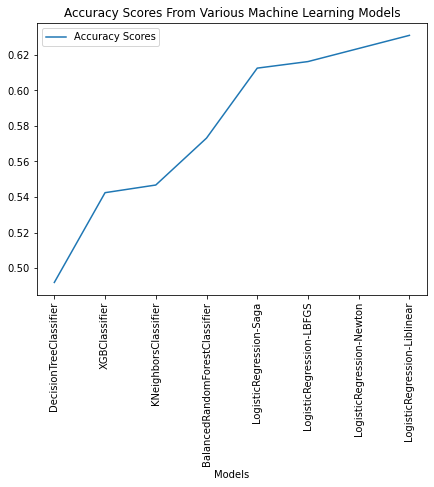

In [72]:
acc_score_df.plot(rot = 90, figsize = (7,5), title = "Accuracy Scores From Various Machine Learning Models")

In [32]:
y_pred = model.predict(X_test)

acc =  accuracy_score(y_test, y_pred)
acc

0.5617529880478087

In [158]:
test_csv = pd.read_csv(Path("Data/misc/test_pitch_df.csv"))

In [159]:
test_csv.set_index("Player", inplace = True)

In [160]:
test_csv.head()

,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP,class
Player,,,,,,,,,,,,,,,,,,,
A.J. Cole,28.0,25.0,0.0,0.0,0.0,26.00,31.0,11.0,30.0,8.0,4.0,3.0,1.0,1.0,0.0,0.0,3.810,1.50,0
A.J. Minter,27.0,36.0,0.0,0.0,0.0,29.10,36.0,23.0,35.0,23.0,3.0,3.0,4.0,5.0,2.0,6.0,7.060,2.01,0
A.J. Puk,25.0,10.0,0.0,0.0,0.0,11.10,10.0,4.0,13.0,5.0,1.0,2.0,0.0,0.0,1.0,2.0,3.180,1.32,0
Aaron Barrett,32.0,3.0,0.0,0.0,0.0,2.10,5.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,15.430,3.86,0
Aaron Brooks,30.0,14.5,9.0,0.0,0.0,54.65,59.0,34.5,41.0,17.0,10.5,3.0,4.0,0.0,0.0,0.0,5.595,1.37,2


In [165]:
X = test_csv.copy()
X.drop(columns = "class", inplace=True)

y = test_csv["class"].ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=87)

X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [166]:
X

,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP
Player,,,,,,,,,,,,,,,,,,
A.J. Cole,28.0,25.0,0.0,0.0,0.0,26.00,31.0,11.0,30.0,8.0,4.0,3.0,1.0,1.0,0.0,0.0,3.810,1.500
A.J. Minter,27.0,36.0,0.0,0.0,0.0,29.10,36.0,23.0,35.0,23.0,3.0,3.0,4.0,5.0,2.0,6.0,7.060,2.010
A.J. Puk,25.0,10.0,0.0,0.0,0.0,11.10,10.0,4.0,13.0,5.0,1.0,2.0,0.0,0.0,1.0,2.0,3.180,1.320
Aaron Barrett,32.0,3.0,0.0,0.0,0.0,2.10,5.0,4.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,15.430,3.860
Aaron Brooks,30.0,14.5,9.0,0.0,0.0,54.65,59.0,34.5,41.0,17.0,10.5,3.0,4.0,0.0,0.0,0.0,5.595,1.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zack Britton,32.0,66.0,0.0,0.0,0.0,61.10,38.0,13.0,53.0,32.0,3.0,3.0,1.0,3.0,4.0,29.0,1.910,1.140
Zack Godley,30.0,16.5,4.5,0.0,0.0,46.00,48.0,30.5,35.0,21.0,7.0,2.0,2.5,1.0,0.0,0.0,5.165,1.455
Zack Greinke,36.0,16.5,16.5,0.0,0.0,104.10,87.5,34.0,93.5,15.0,10.5,9.0,2.5,0.0,0.0,0.0,2.960,1.010


In [151]:
X

In [1]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=1)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

# Calculating the confusion matrix
# cm = confusion_matrix(y_test, predictions)
# cm_df = pd.DataFrame(
#     cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize = [10 , 15])

NameError: name 'train_test_split' is not defined